In [1]:
import cv2
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import plotly.graph_objects as go

import pandas as pd
from collections import defaultdict
import torch as th
## SH factors for lighting
pi = np.pi
constant_factor = np.array([1/np.sqrt(4*pi), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))),
                                ((2*pi)/3)*(np.sqrt(3/(4*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))),
                                (pi/4)*(3)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), 
                                (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))])

def add_SHlight(normal_images, sh_coeff):
    '''
        sh_coeff: [bz, 9, 3]
    '''
    N = normal_images   # [bz, C, H, W]; c=3
    # Extract the Normal images to put into the SH
    sh = np.stack([
            N[:,0]*0.+1.,   # 1
            N[:,0],         # X
            N[:,1],         # Y
            N[:,2],         # Z
            N[:,0]*N[:,1],  # X*Y
            N[:,0]*N[:,2],  # X*Z
            N[:,1]*N[:,2],  # Y*Z
            N[:,0]**2 - N[:,1]**2,  # X**2 - Y**2
            3*(N[:,2]**2) - 1,      # 3(Z**2) - 1
            ], 
            1) # [bz, 9, h, w]
    
    sh = sh * constant_factor[None,:,None,None]
    shading = np.sum(sh_coeff[:,:,:,None,None] * sh[:,:,None,:,:], axis=1) # [bz, 9, 3, h, w]
    return shading

def load_params(path, params_key):

    anno_path = glob.glob(f'{path}/*.txt')
    params = {}
    for k in params_key:
        for p in anno_path:
            # Params
            if k in p:
                print(f'Key=> {k} : Filename=>{p}')
                params[k] = read_params(path=p)

    params_s = swap_key(params)

    all_params = []
    for img_name in params_s:
        each_img = []
        for k in params_key:
            each_img.append(params_s[img_name][k])
        all_params.append(np.concatenate(each_img))
    all_params = np.stack(all_params)

    return params_s, all_params

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def normalize_image(img, convention='CHW'):
    '''
    :params img: the input image
    '''
    if convention == 'CHW':
        agg_axes = (1, 2)
    elif convention == 'HWC':
        agg_axes = (0, 1)
    else: NotImplementedError
    
    img = (img - np.min(img, axis=agg_axes, keepdims=True)) / (np.max(img, axis=agg_axes, keepdims=True) - np.min(img, axis=agg_axes, keepdims=True))
    return img

# Load params
params_key = ['light']
params_train, params_train_arr = load_params(path="/data/mint/DPM_Dataset/ffhq_256_with_anno/params/train/", params_key=params_key)
params_valid, params_valid_arr = load_params(path="/data/mint/DPM_Dataset/ffhq_256_with_anno/params/valid/", params_key=params_key)
print(list(params_valid.keys())[:10])

Key=> light : Filename=>/data/mint/DPM_Dataset/ffhq_256_with_anno/params/train/ffhq-train-light-anno.txt
Key=> light : Filename=>/data/mint/DPM_Dataset/ffhq_256_with_anno/params/valid/ffhq-valid-light-anno.txt
['60000.jpg', '60001.jpg', '60002.jpg', '60003.jpg', '60004.jpg', '60005.jpg', '60006.jpg', '60007.jpg', '60008.jpg', '60009.jpg']


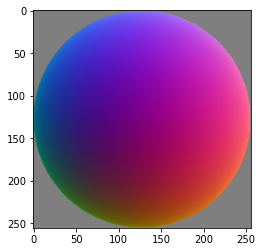

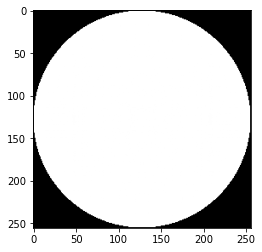

In [2]:
# Create the "Normal map of sphere" using 
img_size = 256
x = np.linspace(-1, 1, img_size)
z = np.linspace(1, -1, img_size)
x, z = np.meshgrid(x, z)

mag = np.sqrt(x**2 + z**2)
valid = mag <=1
y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
x = x * valid
y = y * valid
z = z * valid
normal = np.stack((x, y, z), axis=2)    # Forming x, y, z to Normal maps
plt.imshow((((normal + 1)/2)*255).astype(np.uint8))
plt.show()
norm = np.sqrt(np.sum(normal**2, axis=-1))
plt.imshow(np.stack([norm]*3, axis=-1))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


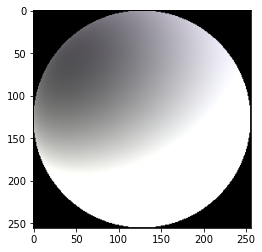

In [3]:
normal_maps = np.transpose(normal, (2, 0, 1))[None, ...]
light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...]
shading_images = add_SHlight(normal_images=normal_maps, sh_coeff=light)
plt.imshow(np.transpose((shading_images * valid)[0], (1, 2, 0)))
plt.show()

(1, 3, 224, 224)


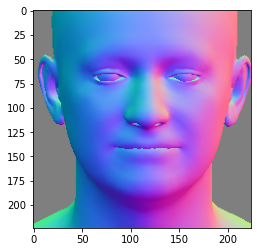

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


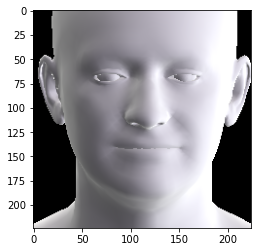

In [4]:
normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]

light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...]
shading_images = add_SHlight(normal_images=normal, sh_coeff=light)
shading_images = shading_images * alpha
print(normal.shape)

plt.imshow(np.transpose(((normal[0] + 1) * 127.5), (1, 2, 0)).astype(np.uint8))
plt.show()
plt.imshow(np.transpose((shading_images)[0], (1, 2, 0)))
plt.show()
# out = normalize_image(shading_images[0], convention='CHW')
# plt.imshow(np.transpose(out, (1, 2, 0)))
# plt.show()

# Rotate the normals

Loaded normals : min=-0.9981995820999146, max=0.9994882345199585, shape=(1, 3, 224, 224)


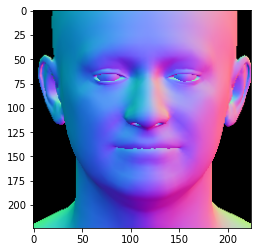

N rotated : min=-0.9981995820999146, max=0.9994882345199585, shape=(3, 224, 224)


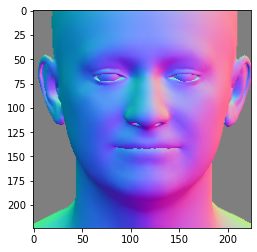

In [5]:
def R_from_angles(x, y, z):
    x = (x/180) * np.pi
    y = (y/180) * np.pi
    z = (z/180) * np.pi
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(x), -np.sin(x)],
        [0, np.sin(x), np.cos(x)]
    ])
    
    Ry = np.array([
        [np.cos(y), 0, np.sin(y)],
        [0, 1, 0],
        [-np.sin(y), 0, np.cos(y)]
    ])
    
    Rz = np.array([
        [np.cos(z), -np.sin(z), 0],
        [np.sin(z), np.cos(z), 0],
        [0, 0, 1]
    ])
    
    R = (Rz @ Ry) @ Rx
    return R
 
normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]
print(f"Loaded normals : min={np.min(normal)}, max={np.max(normal)}, shape={normal.shape}")

b, _, h, w = normal.shape

R = R_from_angles(x=0, y=0, z=0)
assert np.all(np.abs(np.linalg.inv(R) - R.T) < 1e-6)

plt.imshow(np.transpose(((normal[0] + 1) * 127.5)/255.0 * alpha[0], (1, 2, 0)).astype(np.float32))
plt.show()

N_rot = normal[0][:, None, ...] # Extend from [3, h, w] to [3, 1, h, w] for matmul
R = R[..., None, None]  # Extend h, w dims
N_rot = np.einsum('ijhw, jkhw -> ikhw', R, N_rot)
# print("Intrigity : ", np.all(np.abs(N_rot * alpha[0] - N * alpha[0]) < 1e-6))
N_rot = np.squeeze(N_rot, 1) * alpha[0]
print(f"N rotated : min={np.min(N_rot)}, max={np.max(N_rot)}, shape={N_rot.shape}")
plt.imshow(np.transpose((((N_rot + 1) * 127.5)/255.0), (1, 2, 0)).astype(np.float32))
plt.show()


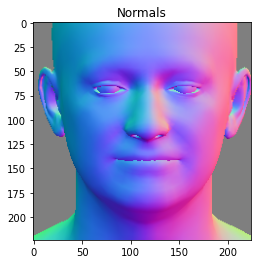

interactive(children=(FloatSlider(value=0.0, description='x', max=360.0, step=1.0), FloatSlider(value=0.0, des…

<function __main__.relight(x, y, z)>

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Load normals/alpha
normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]

# Load light
light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...] # [Bz, 9, 3]

plt.imshow(np.transpose(((normal[0] + 1) * 127.5), (1, 2, 0)).astype(np.uint8))
plt.title("Normals")
plt.show()

def relight(x, y, z):

    # Original 
    shading_images = add_SHlight(normal_images=np.copy(normal), sh_coeff=light)
    shading_images = shading_images * alpha
    rendered = np.transpose((shading_images)[0], (1, 2, 0))
    # plt.title("Shading (No rotated normals)")
    # plt.imshow(final_shading)
    # plt.show()
    
    # Rotated Normals   
    degree = [x, y, z]
    R = R_from_angles(x=x, y=y, z=z)
    assert np.all(np.abs(np.linalg.inv(R) - R.T) < 1e-6)
    # print("Rotation intrigity check : \n", np.abs(np.linalg.inv(R) - R.T) < 1e-6)
    # N = ((normal[0] + 1) * 127.5)/255.0
    

    N_rot = np.copy(normal[0][:, None, ...])
    R = np.copy(R[..., None, None])
    # print(N_rot.shape)
    # print(R.shape)
    N_rot = np.einsum('ijhw, jkhw -> ikhw', R, N_rot)
    N_rot = N_rot.reshape(-1, N_rot.shape[-2], N_rot.shape[-1]) * alpha[0]
    # print(f"N rotated : min={np.min(N_rot)}, max={np.max(N_rot)}, shape={N_rot.shape}")
    
    # plt.title("Normals - Original")
    # plt.imshow(np.transpose(N, (1, 2, 0)).astype(np.float32))
    # plt.show()
    # plt.title("Normals - Rotated")
    # N_rot = np.clip(N_rot, 0, 1)
    # plt.imshow(np.transpose(N_rot, (1, 2, 0)).astype(np.float32))
    # plt.show()
    
    shading_images = add_SHlight(normal_images=N_rot[None, ...], sh_coeff=light)
    shading_images = shading_images * alpha
    rotated_rendered = np.transpose((shading_images)[0], (1, 2, 0))
    
    # Prepare img to show
    N_rot_plot = ((N_rot + 1) * 127.5)/255.0
    N_plot = ((normal[0] + 1) * 127.5)/255.0
    N_rot_plot = np.transpose(N_rot_plot * alpha[0], (1, 2, 0)).astype(np.float32)
    N_plot = np.transpose(N_plot * alpha[0], (1, 2, 0)).astype(np.float32)
    rendered = np.clip(rendered, 0, 1)
    rotated_rendered =np.clip(rotated_rendered, 0, 1)
    
    import torchvision
    show_img = np.stack((N_plot, rendered, N_rot_plot, rotated_rendered), axis=0)
    show_img = np.transpose(show_img, (0, 3, 1, 2))
    grid = torchvision.utils.make_grid(th.tensor(show_img), nrow=2).permute(1, 2, 0)
    plt.figure(figsize=(7, 7), dpi=100)
    plt.imshow(grid)
    plt.title('First row = Original, Second row = Rotated')
    plt.show()

interact(relight, 
        x=widgets.FloatSlider(min=0, max=360, step=1, value=0), 
        y=widgets.FloatSlider(min=0, max=360, step=1, value=0), 
        z=widgets.FloatSlider(min=0, max=360, step=1, value=0), 
    )

# Manually change the lightning

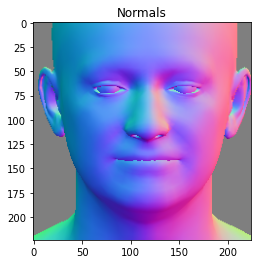

interactive(children=(FloatSlider(value=0.0, description='sh1', max=10.0, min=-10.0), FloatSlider(value=0.0, d…

<function __main__.relight(sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9)>

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Load normals/alpha
normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]

# Load light
light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...] # [Bz, 9, 3]

plt.imshow(np.transpose(((normal[0] + 1) * 127.5), (1, 2, 0)).astype(np.uint8))
plt.title("Normals")
plt.show()

def relight(sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9):

    SH = [sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9]

    mod_light = light.copy() * 0
    mod_light[:, 0, :] = light[:, 0, :].copy() + sh1
    mod_light[:, 1, :] = light[:, 1, :].copy() + sh2
    mod_light[:, 2, :] = light[:, 2, :].copy() + sh3
    mod_light[:, 3, :] = light[:, 3, :].copy() + sh4
    mod_light[:, 4, :] = light[:, 4, :].copy() + sh5
    mod_light[:, 5, :] = light[:, 5, :].copy() + sh6
    mod_light[:, 6, :] = light[:, 6, :].copy() + sh7
    mod_light[:, 7, :] = light[:, 7, :].copy() + sh8
    mod_light[:, 8, :] = light[:, 8, :].copy() + sh9

    shading_images = add_SHlight(normal_images=normal.copy(), sh_coeff=mod_light)
    shading_images = shading_images * alpha

    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(np.transpose((shading_images)[0], (1, 2, 0)))
    # ax[0].set_title(f"Defualt : light + {SH}")

    out = normalize_image(shading_images[0], convention='CHW')
    out = (out[None, ...] * alpha)[0]

    # final_shading = np.concatenate((np.transpose((shading_images)[0], (1, 2, 0)), np.transpose(out, (1, 2, 0))), axis=1)
    final_shading = np.transpose(out, (1, 2, 0))
    # ax[1].imshow(np.transpose(out, (1, 2, 0)))
    # ax[1].set_title(f"Normalized : light + {SH}")

    plt.imshow(final_shading)
    plt.title(f"Normalized : light + {SH}")
    plt.show()

bound = 10

interact(relight, 
        sh1=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh2=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh3=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh4=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh5=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh6=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh7=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh8=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh9=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
    )


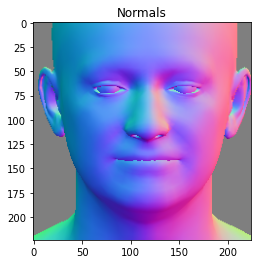

interactive(children=(FloatSlider(value=0.0, description='sh01', max=10.0, min=-10.0), FloatSlider(value=0.0, …

<function __main__.relight_fined(sh01, sh02, sh03, sh11, sh12, sh13, sh21, sh22, sh23, sh31, sh32, sh33, sh41, sh42, sh43, sh51, sh52, sh53, sh61, sh62, sh63, sh71, sh72, sh73, sh81, sh82, sh83)>

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Load normals/alpha
normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]

# Load light
light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...] # [Bz, 9, 3]

plt.imshow(np.transpose(((normal[0] + 1) * 127.5), (1, 2, 0)).astype(np.uint8))
plt.title("Normals")
plt.show()

def relight_fined(
    sh01, sh02, sh03, 
    sh11, sh12, sh13, 
    sh21, sh22, sh23,
    sh31, sh32, sh33, 
    sh41, sh42, sh43, 
    sh51, sh52, sh53,
    sh61, sh62, sh63, 
    sh71, sh72, sh73, 
    sh81, sh82, sh83,
    ):

    SH = [sh01, sh02, sh03, 
        sh11, sh12, sh13, 
        sh21, sh22, sh23,
        sh31, sh32, sh33, 
        sh41, sh42, sh43, 
        sh51, sh52, sh53,
        sh61, sh62, sh63, 
        sh71, sh72, sh73, 
        sh81, sh82, sh83,]

    mod_light = light.copy() * 0
    print(light[:, 0, :].shape, np.array([[sh01, sh02, sh03]]).shape)
    mod_light[:, 0, :] = light[:, 0, :].copy() + np.array([[sh01, sh02, sh03]])
    mod_light[:, 1, :] = light[:, 1, :].copy() + np.array([[sh11, sh12, sh13]])
    mod_light[:, 2, :] = light[:, 2, :].copy() + np.array([[sh21, sh22, sh23]])
    mod_light[:, 3, :] = light[:, 3, :].copy() + np.array([[sh31, sh32, sh33]])
    mod_light[:, 4, :] = light[:, 4, :].copy() + np.array([[sh41, sh42, sh43]])
    mod_light[:, 5, :] = light[:, 5, :].copy() + np.array([[sh51, sh52, sh53]])
    mod_light[:, 6, :] = light[:, 6, :].copy() + np.array([[sh61, sh62, sh63]])
    mod_light[:, 7, :] = light[:, 7, :].copy() + np.array([[sh71, sh72, sh73]])
    mod_light[:, 8, :] = light[:, 8, :].copy() + np.array([[sh81, sh82, sh83]])

    shading_images = add_SHlight(normal_images=normal.copy(), sh_coeff=mod_light)
    shading_images = shading_images * alpha

    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(np.transpose((shading_images)[0], (1, 2, 0)))
    # ax[0].set_title(f"Defualt : light + {SH}")

    out = normalize_image(shading_images[0], convention='CHW')
    out = (out[None, ...] * alpha)[0]

    # final_shading = np.concatenate((np.transpose((shading_images)[0], (1, 2, 0)), np.transpose(out, (1, 2, 0))), axis=1)
    final_shading = np.transpose(out, (1, 2, 0))
    # ax[1].imshow(np.transpose(out, (1, 2, 0)))
    # ax[1].set_title(f"Normalized : light + {SH}")

    plt.imshow(final_shading)
    plt.title(f"Normalized : light + {SH}")
    plt.show()

bound = 10

interact(relight_fined, 
        sh01=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh02=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh03=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh11=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh12=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh13=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh21=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh22=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh23=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh31=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh32=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh33=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh41=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh42=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh43=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh51=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh52=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh53=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh61=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh62=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh63=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh71=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh72=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh73=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

        sh81=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh82=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 
        sh83=widgets.FloatSlider(min=-bound, max=bound, step=0.1, value=0), 

    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


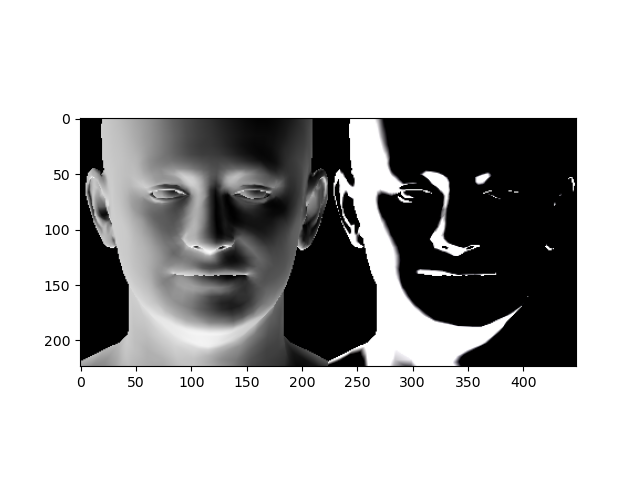

In [ ]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

from mpl_interactions import ipyplot as iplt

normal = np.load('./normals/normals_60008.npy', allow_pickle=True)
alpha = np.load('./alpha/alpha_60008.npy', allow_pickle=True)
normal = np.transpose(normal, (2, 0, 1))[None, ...]
alpha = np.transpose(alpha, (2, 0, 1))[None, ...]
light = params_valid['60008.jpg']['light'].reshape(9, 3)[None, ...]

def relight2(sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9):

    SH = [sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9]

    mod_light = light.copy() * 0
    mod_light[:, 0, :] = light[:, 0, :].copy() + sh1
    mod_light[:, 1, :] = light[:, 1, :].copy() + sh2
    mod_light[:, 2, :] = light[:, 2, :].copy() + sh3
    mod_light[:, 3, :] = light[:, 3, :].copy() + sh4
    mod_light[:, 4, :] = light[:, 4, :].copy() + sh5
    mod_light[:, 5, :] = light[:, 5, :].copy() + sh6
    mod_light[:, 6, :] = light[:, 6, :].copy() + sh7
    mod_light[:, 7, :] = light[:, 7, :].copy() + sh8
    mod_light[:, 8, :] = light[:, 8, :].copy() + sh9

    shading_images = add_SHlight(normal_images=normal, sh_coeff=mod_light)
    shading_images = shading_images * alpha

    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(np.transpose((shading_images)[0], (1, 2, 0)))
    # ax[0].set_title(f"Defualt : light + {SH}")

    out = normalize_image(shading_images[0], convention='CHW')
    out = (out[None, ...] * alpha)[0]
    # ax[1].imshow(np.transpose(out, (1, 2, 0)))
    # ax[1].set_title(f"Normalized : light + {SH}")
    # plt.show()

    final_out = np.concatenate((np.transpose(out, (1, 2, 0)), np.transpose((shading_images)[0], (1, 2, 0))), axis=1)
    return final_out

# def f(param1, param2):
#     return np.sin(X) * param2 + np.exp(np.cos(Y * param1)) + param2
fig, ax = plt.subplots()
bound = 5
step = 250
slider_val = np.linspace(-bound, bound, step)
slider_val = np.concatenate((slider_val[slider_val<0], [0], slider_val[slider_val>0]))

controls = iplt.imshow(relight2, 
        sh1=slider_val,
        sh2=slider_val,
        sh3=slider_val,
        sh4=slider_val,
        sh5=slider_val,
        sh6=slider_val,
        sh7=slider_val,
        sh8=slider_val,
        sh9=slider_val,
        play_buttons=True
    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


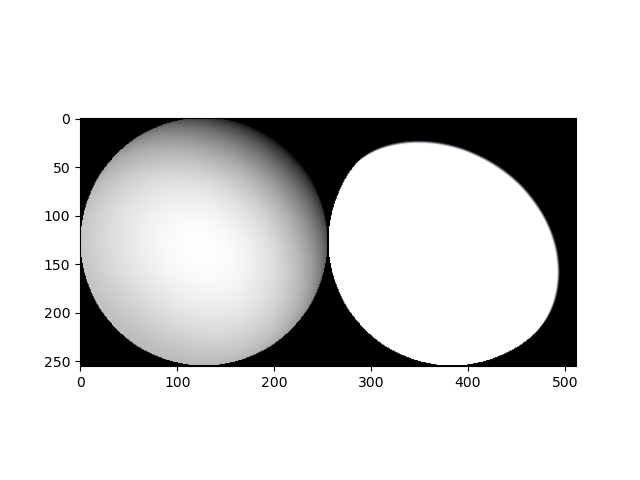

In [ ]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

from mpl_interactions import ipyplot as iplt

# Create the "Normal map of sphere" using 
img_size = 256
x = np.linspace(-1, 1, img_size)
z = np.linspace(1, -1, img_size)
x, z = np.meshgrid(x, z)

mag = np.sqrt(x**2 + z**2)
alpha = mag <=1
y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
x = x * valid
y = y * valid
z = z * valid
normal = np.stack((x, y, z), axis=2)    # Forming x, y, z to Normal maps
normal = np.transpose(normal, (2, 0, 1))[None, ...]

def relight2(sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9):

    SH = [sh1, sh2, sh3, sh4, sh5, sh6, sh7, sh8, sh9]

    mod_light = light.copy() * 0
    mod_light[:, 0, :] = light[:, 0, :].copy() + sh1
    mod_light[:, 1, :] = light[:, 1, :].copy() + sh2
    mod_light[:, 2, :] = light[:, 2, :].copy() + sh3
    mod_light[:, 3, :] = light[:, 3, :].copy() + sh4
    mod_light[:, 4, :] = light[:, 4, :].copy() + sh5
    mod_light[:, 5, :] = light[:, 5, :].copy() + sh6
    mod_light[:, 6, :] = light[:, 6, :].copy() + sh7
    mod_light[:, 7, :] = light[:, 7, :].copy() + sh8
    mod_light[:, 8, :] = light[:, 8, :].copy() + sh9

    shading_images = add_SHlight(normal_images=normal, sh_coeff=mod_light)
    shading_images = shading_images * alpha

    # fig, ax = plt.subplots(1, 2)
    # ax[0].imshow(np.transpose((shading_images)[0], (1, 2, 0)))
    # ax[0].set_title(f"Defualt : light + {SH}")

    out = normalize_image(shading_images[0], convention='CHW')
    out = (out[None, ...] * alpha)[0]
    # ax[1].imshow(np.transpose(out, (1, 2, 0)))
    # ax[1].set_title(f"Normalized : light + {SH}")
    # plt.show()

    final_out = np.concatenate((np.transpose(out, (1, 2, 0)), np.transpose((shading_images)[0], (1, 2, 0))), axis=1)
    return final_out

fig, ax = plt.subplots()
bound = 10
step = 250
slider_val = np.linspace(-bound, bound, step)
slider_val = np.concatenate((slider_val[slider_val<0], [0], slider_val[slider_val>0]))

controls = iplt.imshow(relight2, 
        sh1=slider_val,
        sh2=slider_val,
        sh3=slider_val,
        sh4=slider_val,
        sh5=slider_val,
        sh6=slider_val,
        sh7=slider_val,
        sh8=slider_val,
        sh9=slider_val,
        play_buttons=True
    )

plt.show()